In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from keras.layers import Dense, Flatten
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [6]:
# EDA - Exploratory Data Analysis

train_datagen = ImageDataGenerator(zoom_range=0.5, shear_range=0.3, horizontal_flip=True, preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [27]:
train = train_datagen.flow_from_directory(directory="PlantDiseases//train", target_size=(256, 256), batch_size=32)

valid = val_datagen.flow_from_directory(directory="PlantDiseases//valid", target_size=(256, 256), batch_size=32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


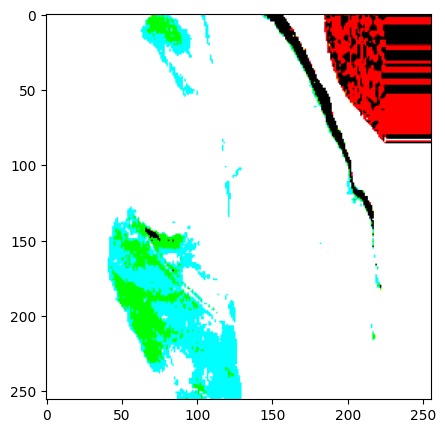

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


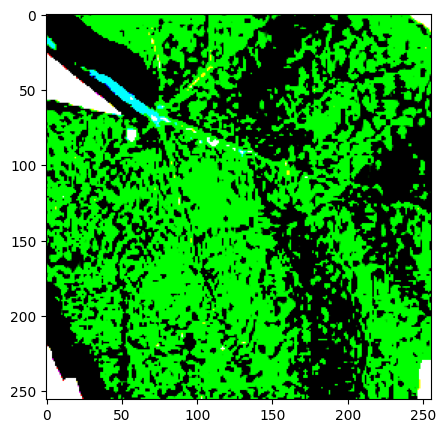

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


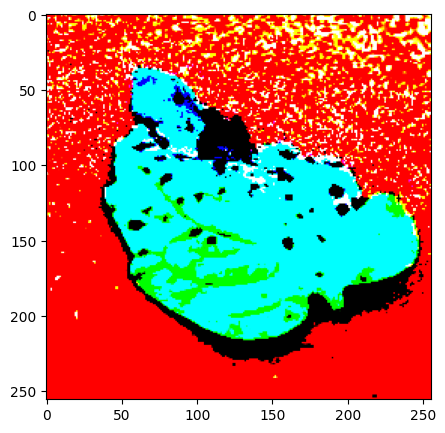

In [8]:
train_img, label = train.next()
train_img.shape


def plotImage(img_arr, label):
    for img, l in zip(img_arr, label):
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.show()


plotImage(train_img[:3], label[:3])

In [9]:
# Creating Model

base_model = VGG19(input_shape=(256, 256, 3), include_top=False)

In [10]:
for layer in base_model.layers:
    layer.trainable = False

X = Flatten()(base_model.output)
X = Dense(units=38, activation="softmax")(X)

In [11]:
# build main model using functional API

model = Model(base_model.input, X)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [12]:
model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])

In [13]:
# EarlyStopping

es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=3, verbose=1)

# ModelCheckpoint

mc = ModelCheckpoint(filepath="bestmodel.h5", monitor="val_accuracy", min_delta=0.01, patience=3, verbose=1, save_best_only=True)

cb = [es, mc]

In [14]:
history = model.fit_generator(train, steps_per_epoch=16, epochs=50, verbose=1, callbacks=cb, validation_data=valid, validation_steps=16)

C:\Users\kimiu\AppData\Local\Temp\ipykernel_10228\1706190447.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train, steps_per_epoch=16, epochs=50, verbose=1, callbacks=cb, validation_data=valid, validation_steps=16)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 28.8588 - accuracy: 0.1777
Epoch 1: val_accuracy improved from -inf to 0.41406, saving model to bestmodel.h5
16/16 [==============================] - 133s 9s/step - loss: 28.8588 - accuracy: 0.1777 - val_loss: 14.9537 - val_accuracy: 0.4141
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 14.1354 - accuracy: 0.4336
Epoch 2: val_accuracy improved from 0.41406 to 0.49805, saving model to bestmodel.h5
16/16 [==============================] - 144s 9s/step - loss: 14.1354 - accuracy: 0.4336 - val_loss: 12.4355 - val_accuracy: 0.4980
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 11.8455 - accuracy: 0.5332
Epoch 3: val_accuracy improved from 0.49805 to 0.57227, saving model to bestmodel.h5
16/16 [==============================] - 148s 10s/step - loss: 11.8455 - accuracy: 0.5332 - val_loss: 10.3757 - val_accuracy: 0.5723
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss

In [16]:
h = history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

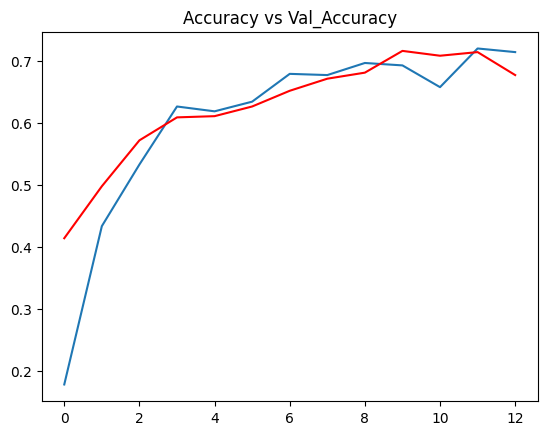

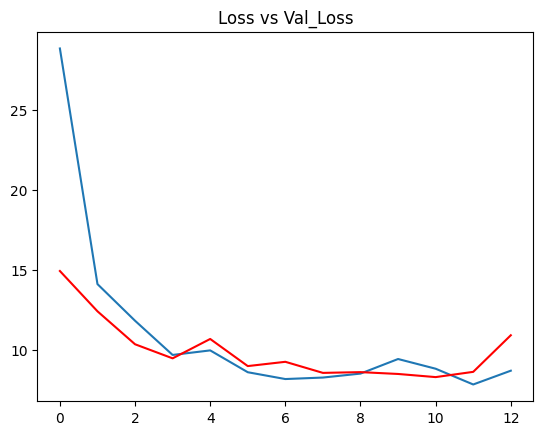

In [17]:
plt.plot(h["accuracy"])
plt.plot(h["val_accuracy"], c="red")
plt.title("Accuracy vs Val_Accuracy")
plt.show()

plt.plot(h["loss"])
plt.plot(h["val_loss"], c="red")
plt.title("Loss vs Val_Loss")
plt.show()

In [24]:
# load bestmodel

model = load_model("bestmodel.h5")

In [29]:
# evaluate the model

accuracy = model.evaluate(valid)[1]
print(f"The accuracy of our model is {accuracy*100}%")

550/550 [==============================] - 2408s 4s/step - loss: 5.5751 - accuracy: 0.7800
The accuracy of our model is 77.99909114837646%


In [40]:
ref = zip(list(train.class_indices.values()), list(train.class_indices.keys()))

38

In [45]:
def prediction(path):
    img = load_img(path, target_size=(256, 256))
    i = img_to_array(img)

    image1 = preprocess_input(i)

    image = np.expand_dims(image1, axis=0)

    pred = np.argmax(model.predict(image))

    print(f"the image refers to {ref[pred]}")